In [1]:
import gc
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
np.random.seed(2020)

In [2]:
def reduzirMemoria(df):
    reduzirType = ['int16', 'float16', 'int32', 'float32', 'int64', 'float64']
    print('Memoria Inicial:', df.memory_usage().sum() / 1024 ** 2)
    
    for item in df.columns:
        itemType = df[item].dtypes
        
        if itemType in reduzirType:
            vmin, vmax = df[item].min(), df[item].max()
           
            if str(itemType).find('int') >= 0:
                if vmin >= np.iinfo(np.int8).min and vmax <= np.iinfo(np.int8).max:
                    df[item] = df[item].astype(np.int8)
                elif vmin >= np.iinfo(np.int16).min and vmax <= np.iinfo(np.int16).max:
                    df[item] = df[item].astype(np.int16)
                elif vmin >= np.iinfo(np.int32).min and vmax <= np.iinfo(np.int32).max:
                    df[item] = df[item].astype(np.int32)
                elif vmin >= np.iinfo(np.int64).min and vmax <= np.iinfo(np.int64).max:
                    df[item] = df[item].astype(np.int64)  
            
            else:
                if vmin >= np.finfo(np.float16).min and vmax <= np.finfo(np.float16).max:
                    df[item] = df[item].astype(np.float16)
                elif vmin >= np.finfo(np.float32).min and vmax <= np.finfo(np.float32).max:
                    df[item] = df[item].astype(np.float32)
                else:
                    df[item] = df[item].astype(np.float64)    
                    
    print('Memoria Final:', df.memory_usage().sum() / 1024 ** 2)

In [3]:
def showCorr(df):
    fig = plt.subplots(figsize = (20, 20))
    sns.set(font_scale=1.5)
    sns.heatmap(df.corr(),square = True,cbar=True,annot=True,annot_kws={'size': 10})
    plt.show()

In [4]:
def create_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [5]:
def set_map_df(df):
    df['authorized_flag'] = df['authorized_flag'].map({'N':0, 'Y':1})
    df['category_1'] = df['category_1'].map({'N':0, 'Y':1}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2})   

In [6]:
def set_fillna_df(df):    
    df['installments'].replace({-1: np.nan, 999: np.nan}, inplace=True)
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    print('Percentile Purchase_Amount:',np.percentile(df['purchase_amount'], [1, 5, 50, 95, 99]))
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.9))

In [7]:
def set_date_df(df):
    pDate = pd.to_datetime(df['purchase_date'])
    df['purchase_date'] = pDate
    df['year'] = pDate.dt.year
    df['weekofyear'] = pDate.dt.weekofyear
    df['month'] = pDate.dt.month
    df['dayofweek'] = pDate.dt.dayofweek
    df['weekend'] = (pDate.dt.weekday >=5).astype(int)
    df['hour'] = pDate.dt.hour
    df['month_diff'] = ((datetime.datetime.today() - pDate).dt.days)//30
    df['month_diff'] += df['month_lag']
    
    df['month_rank'] = df.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=False)
    df['date_rank'] = df.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=False)

In [8]:
def get_list_aggregation():
    aggs = {}
    aggs['card_id'] = ['size', 'count']
    aggs['year'] = ['nunique', 'mean']
    aggs['purchase_date'] = ['max','min', 'nunique']
    
    for col in ['purchase_amount', 'installments']:
        aggs[col] = ['min', 'max', 'mean', 'sum', 'std', 'var']
        
    for col in ['month', 'hour', 'weekofyear', 'dayofweek', 'month_lag', 'month_diff']:
        aggs[col] = ['nunique', 'min', 'max', 'mean', 'var']
    
    for col in ['authorized_flag', 'weekend']:
        aggs[col] = ['sum', 'mean', 'nunique']
        
    for col in ['category_1', 'category_2', 'category_3']:
        aggs[col] = ['nunique', 'min', 'max', 'mean', 'sum', 'std']
        
    for col in ['month_rank', 'date_rank']:
        aggs[col] = ['sum', 'mean', 'min', 'nunique', 'std']
        
    for col in ['subsector_id','merchant_id','merchant_category_id', 'state_id', 'city_id']:
        aggs[col] = ['nunique']
    
    return aggs

In [9]:
def set_purchase_amount_by_category(df):
    items = ['min', 'max', 'mean', 'sum', 'std']
    for col in ['category_2','category_3']:
        for item in items:
            df[col+item] = df.groupby([col])['purchase_amount'].transform(item)

In [10]:
def set_purchase_date_group(df, pred):
    col = pred + '_purchase_date_'
    df[col+'diff'] = (df[col+'max'] - df[col+'min']).dt.days
    df[col+'average'] = df[col+'diff'] / df[pred+'_card_id_size']
    df[col+'uptonow'] = (datetime.datetime.today() - df[col+'max']).dt.days
    df[col+'uptomin'] = (datetime.datetime.today() - df[col+'min']).dt.days 

In [11]:
dir_local = '../input/dsa-jun2019/'
dir_dsa = '../input/competicao-dsa-machine-learning-jun-2019/'

In [12]:
train_df = pd.read_csv(dir_dsa + 'dataset_treino.csv')
test_df = pd.read_csv(dir_dsa + 'dataset_teste.csv')

In [13]:
novas_vendas = pd.read_csv(dir_local + 'novas_transacoes_comerciantes.csv')
reduzirMemoria(novas_vendas)

Memoria Inicial: 209.67440795898438
Memoria Final: 114.19770336151123


In [14]:
vendas = pd.read_csv(dir_local + 'transacoes_historicas.csv')
reduzirMemoria(vendas)

Memoria Inicial: 3109.5357055664062
Memoria Final: 1749.1138677597046


In [15]:
train_df.describe().T

count      mean    ...           75%        max
feature_1  201917.0  3.105311    ...      4.000000   5.000000
feature_2  201917.0  1.745410    ...      2.000000   3.000000
feature_3  201917.0  0.565569    ...      1.000000   1.000000
target     201917.0 -0.393636    ...      0.765453  17.965068

[4 rows x 8 columns]

In [16]:
test_df.describe().T

count      mean       std  min  25%  50%  75%  max
feature_1  123623.0  3.109260  1.189110  1.0  2.0  3.0  4.0  5.0
feature_2  123623.0  1.741796  0.749195  1.0  1.0  2.0  2.0  3.0
feature_3  123623.0  0.564377  0.495840  0.0  0.0  1.0  1.0  1.0

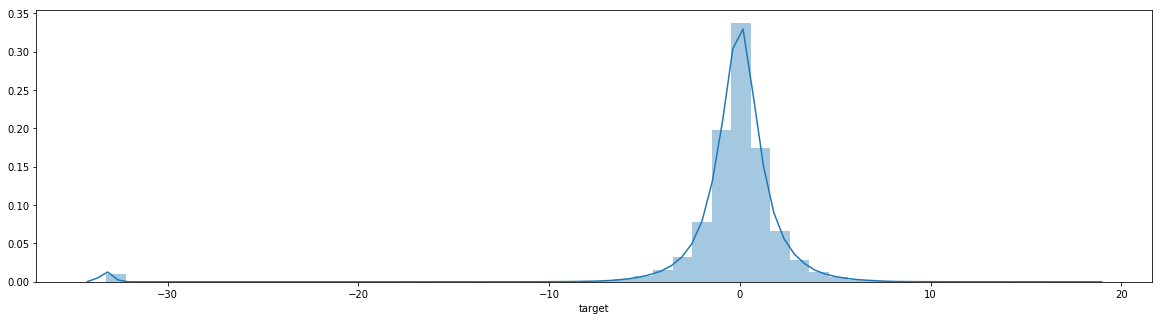

In [17]:
plt.figure(figsize=(20, 5))
sns.distplot(train_df.target)
plt.show()

In [18]:
set_fillna_df(vendas)
set_map_df(vendas)
set_date_df(vendas)
set_purchase_amount_by_category(vendas)
vendas.describe().T

Percentile Purchase_Amount: [-0.74324131 -0.73819244 -0.68834949 -0.1686125   1.22084095]


count      ...                  max
authorized_flag       29112361.0      ...             1.000000
city_id               29112361.0      ...           347.000000
category_1            29112361.0      ...             1.000000
installments          28934014.0      ...            12.000000
category_3            29112361.0      ...             2.000000
merchant_category_id  29112361.0      ...           891.000000
month_lag             29112361.0      ...             0.000000
purchase_amount       29112361.0      ...             0.900000
category_2            29112361.0      ...             5.000000
state_id              29112361.0      ...            24.000000
subsector_id          29112361.0      ...            41.000000
year                  29112361.0      ...          2018.000000
weekofyear            29112361.0      ...            52.000000
month                 29112361.0      ...            12.000000
dayofweek             29112361.0      ...             6.000000
weekend               29112361.0      ...             1.000000
hour                  29112361.0      ...            23.000000
month_diff            29112361.0      ...            29.000000
month_rank            29112361.0      ...            14.000000
date_rank             29112361.0      ...          5542.000000
category_2min         29112361.0      ...            -0.746893
category_2max         29112361.0      ...             0.900000
category_2mean        29112361.0      ...            -0.589080
category_2sum         29112361.0      ...       -610474.300864
category_2std         29112361.0      ...             0.274554
category_3min         29112361.0      ...            -0.746893
category_3max         29112361.0      ...             0.900000
category_3mean        29112361.0      ...            -0.177149
category_3sum         29112361.0      ...       -326828.587341
category_3std         29112361.0      ...             0.505677

[30 rows x 8 columns]

In [19]:
aggs = get_list_aggregation()
aggs

{'card_id': ['size', 'count'],
 'year': ['nunique', 'mean'],
 'purchase_date': ['max', 'min', 'nunique'],
 'purchase_amount': ['min', 'max', 'mean', 'sum', 'std', 'var'],
 'installments': ['min', 'max', 'mean', 'sum', 'std', 'var'],
 'month': ['nunique', 'min', 'max', 'mean', 'var'],
 'hour': ['nunique', 'min', 'max', 'mean', 'var'],
 'weekofyear': ['nunique', 'min', 'max', 'mean', 'var'],
 'dayofweek': ['nunique', 'min', 'max', 'mean', 'var'],
 'month_lag': ['nunique', 'min', 'max', 'mean', 'var'],
 'month_diff': ['nunique', 'min', 'max', 'mean', 'var'],
 'authorized_flag': ['sum', 'mean', 'nunique'],
 'weekend': ['sum', 'mean', 'nunique'],
 'category_1': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'category_2': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'category_3': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'month_rank': ['sum', 'mean', 'min', 'nunique', 'std'],
 'date_rank': ['sum', 'mean', 'min', 'nunique', 'std'],
 'subsector_id': ['nunique'],
 'merchant_id':

In [20]:
new_columns = create_new_columns('hist', aggs)
new_columns

['hist_card_id_size',
 'hist_card_id_count',
 'hist_year_nunique',
 'hist_year_mean',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_purchase_date_nunique',
 'hist_purchase_amount_min',
 'hist_purchase_amount_max',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_std',
 'hist_purchase_amount_var',
 'hist_installments_min',
 'hist_installments_max',
 'hist_installments_mean',
 'hist_installments_sum',
 'hist_installments_std',
 'hist_installments_var',
 'hist_month_nunique',
 'hist_month_min',
 'hist_month_max',
 'hist_month_mean',
 'hist_month_var',
 'hist_hour_nunique',
 'hist_hour_min',
 'hist_hour_max',
 'hist_hour_mean',
 'hist_hour_var',
 'hist_weekofyear_nunique',
 'hist_weekofyear_min',
 'hist_weekofyear_max',
 'hist_weekofyear_mean',
 'hist_weekofyear_var',
 'hist_dayofweek_nunique',
 'hist_dayofweek_min',
 'hist_dayofweek_max',
 'hist_dayofweek_mean',
 'hist_dayofweek_var',
 'hist_month_lag_nunique',
 'hist_month_lag_min',
 'hist_

In [21]:
vendas_group = vendas.groupby('card_id').agg(aggs)

In [22]:
del vendas; gc.collect()

35

In [23]:
vendas_group.columns = new_columns
vendas_group.reset_index(drop=False,inplace=True)

In [24]:
set_purchase_date_group(vendas_group, 'hist')

In [25]:
train_df = train_df.merge(vendas_group,on='card_id',how='left')
test_df = test_df.merge(vendas_group,on='card_id',how='left')

In [26]:
del vendas_group; gc.collect()

35

In [27]:
set_fillna_df(novas_vendas)
set_map_df(novas_vendas)
set_date_df(novas_vendas)
set_purchase_amount_by_category(novas_vendas)
novas_vendas.describe().T

Percentile Purchase_Amount: [-0.7421875  -0.73632812 -0.67480469 -0.08575439  1.46289062]


count      ...                max
authorized_flag       1963031.0      ...           1.000000
city_id               1963031.0      ...         347.000000
category_1            1963031.0      ...           1.000000
installments          1907107.0      ...          12.000000
category_3            1963031.0      ...           2.000000
merchant_category_id  1963031.0      ...         891.000000
month_lag             1963031.0      ...           2.000000
purchase_amount       1963031.0      ...           0.900000
category_2            1963031.0      ...           5.000000
state_id              1963031.0      ...          24.000000
subsector_id          1963031.0      ...          41.000000
year                  1963031.0      ...        2018.000000
weekofyear            1963031.0      ...          52.000000
month                 1963031.0      ...          12.000000
dayofweek             1963031.0      ...           6.000000
weekend               1963031.0      ...           1.000000
hour                  1963031.0      ...          23.000000
month_diff            1963031.0      ...          29.000000
month_rank            1963031.0      ...           2.000000
date_rank             1963031.0      ...         109.000000
category_2min         1963031.0      ...          -0.747070
category_2max         1963031.0      ...           0.900000
category_2mean        1963031.0      ...          -0.578286
category_2sum         1963031.0      ...      -38061.060777
category_2std         1963031.0      ...           0.280224
category_3min         1963031.0      ...          -0.746094
category_3max         1963031.0      ...           0.900000
category_3mean        1963031.0      ...          -0.185927
category_3sum         1963031.0      ...      -27644.865467
category_3std         1963031.0      ...           0.493721

[30 rows x 8 columns]

In [28]:
aggs = get_list_aggregation()
aggs

{'card_id': ['size', 'count'],
 'year': ['nunique', 'mean'],
 'purchase_date': ['max', 'min', 'nunique'],
 'purchase_amount': ['min', 'max', 'mean', 'sum', 'std', 'var'],
 'installments': ['min', 'max', 'mean', 'sum', 'std', 'var'],
 'month': ['nunique', 'min', 'max', 'mean', 'var'],
 'hour': ['nunique', 'min', 'max', 'mean', 'var'],
 'weekofyear': ['nunique', 'min', 'max', 'mean', 'var'],
 'dayofweek': ['nunique', 'min', 'max', 'mean', 'var'],
 'month_lag': ['nunique', 'min', 'max', 'mean', 'var'],
 'month_diff': ['nunique', 'min', 'max', 'mean', 'var'],
 'authorized_flag': ['sum', 'mean', 'nunique'],
 'weekend': ['sum', 'mean', 'nunique'],
 'category_1': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'category_2': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'category_3': ['nunique', 'min', 'max', 'mean', 'sum', 'std'],
 'month_rank': ['sum', 'mean', 'min', 'nunique', 'std'],
 'date_rank': ['sum', 'mean', 'min', 'nunique', 'std'],
 'subsector_id': ['nunique'],
 'merchant_id':

In [29]:
new_columns = create_new_columns('new', aggs)
new_columns

['new_card_id_size',
 'new_card_id_count',
 'new_year_nunique',
 'new_year_mean',
 'new_purchase_date_max',
 'new_purchase_date_min',
 'new_purchase_date_nunique',
 'new_purchase_amount_min',
 'new_purchase_amount_max',
 'new_purchase_amount_mean',
 'new_purchase_amount_sum',
 'new_purchase_amount_std',
 'new_purchase_amount_var',
 'new_installments_min',
 'new_installments_max',
 'new_installments_mean',
 'new_installments_sum',
 'new_installments_std',
 'new_installments_var',
 'new_month_nunique',
 'new_month_min',
 'new_month_max',
 'new_month_mean',
 'new_month_var',
 'new_hour_nunique',
 'new_hour_min',
 'new_hour_max',
 'new_hour_mean',
 'new_hour_var',
 'new_weekofyear_nunique',
 'new_weekofyear_min',
 'new_weekofyear_max',
 'new_weekofyear_mean',
 'new_weekofyear_var',
 'new_dayofweek_nunique',
 'new_dayofweek_min',
 'new_dayofweek_max',
 'new_dayofweek_mean',
 'new_dayofweek_var',
 'new_month_lag_nunique',
 'new_month_lag_min',
 'new_month_lag_max',
 'new_month_lag_mean',
 'n

In [30]:
novas_vendas_group = novas_vendas.groupby('card_id').agg(aggs)

In [31]:
del novas_vendas; gc.collect()

77

In [32]:
novas_vendas_group.columns = new_columns
novas_vendas_group.reset_index(drop=False,inplace=True)

In [33]:
set_purchase_date_group(novas_vendas_group, 'new')

In [34]:
train_df = train_df.merge(novas_vendas_group,on='card_id',how='left')
test_df = test_df.merge(novas_vendas_group,on='card_id',how='left')

In [35]:
del novas_vendas_group; gc.collect()

21

In [36]:
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
outls = train_df['outliers'].value_counts()
print("Outliers: {}".format(outls))

Outliers: 0    199710
1      2207
Name: outliers, dtype: int64


In [37]:
## process both train and test
for df in [train_df, test_df]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']

In [38]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

In [39]:
train_df.describe().T

count      ...                max
feature_1                         201917.0      ...       1.314462e-02
feature_2                         201917.0      ...       1.416640e-02
feature_3                         201917.0      ...       1.142752e-02
target                            201917.0      ...       1.796507e+01
hist_card_id_size                 201917.0      ...       2.912000e+03
hist_card_id_count                201917.0      ...       2.912000e+03
hist_year_nunique                 201917.0      ...       2.000000e+00
hist_year_mean                    201917.0      ...       2.017993e+03
hist_purchase_date_max            201917.0      ...       1.519862e+09
hist_purchase_date_min            201917.0      ...       1.514762e+09
hist_purchase_date_nunique        201917.0      ...       2.912000e+03
hist_purchase_amount_min          201917.0      ...       9.000000e-01
hist_purchase_amount_max          201917.0      ...       9.000000e-01
hist_purchase_amount_mean         201917.0      ...       9.000000e-01
hist_purchase_amount_sum          201917.0      ...       3.774611e+02
hist_purchase_amount_std          201917.0      ...       1.142226e+00
hist_purchase_amount_var          201917.0      ...       1.304681e+00
hist_installments_min             201917.0      ...       1.000000e+01
hist_installments_max             201917.0      ...       1.200000e+01
hist_installments_mean            201917.0      ...       1.180000e+01
hist_installments_sum             201917.0      ...       2.075000e+03
hist_installments_std             201910.0      ...       7.778175e+00
hist_installments_var             201910.0      ...       6.050000e+01
hist_month_nunique                201917.0      ...       1.200000e+01
hist_month_min                    201917.0      ...       1.100000e+01
hist_month_max                    201917.0      ...       1.200000e+01
hist_month_mean                   201917.0      ...       1.198507e+01
hist_month_var                    201917.0      ...       6.050000e+01
hist_hour_nunique                 201917.0      ...       2.400000e+01
hist_hour_min                     201917.0      ...       2.200000e+01
...                                    ...      ...                ...
new_date_rank_sum                 179986.0      ...       5.995000e+03
new_date_rank_mean                179986.0      ...       5.500000e+01
new_date_rank_min                 179986.0      ...       1.000000e+00
new_date_rank_nunique             179986.0      ...       1.090000e+02
new_date_rank_std                 153199.0      ...       3.160960e+01
new_subsector_id_nunique          179986.0      ...       2.400000e+01
new_merchant_id_nunique           179986.0      ...       1.090000e+02
new_merchant_category_id_nunique  179986.0      ...       4.000000e+01
new_state_id_nunique              179986.0      ...       1.400000e+01
new_city_id_nunique               179986.0      ...       2.800000e+01
new_purchase_date_diff            179986.0      ...       6.100000e+01
new_purchase_date_average         179986.0      ...       3.000000e+01
new_purchase_date_uptonow         179986.0      ...       8.480000e+02
new_purchase_date_uptomin         179986.0      ...       8.510000e+02
outliers                          201917.0      ...       1.000000e+00
dayofweek                         201917.0      ...       6.000000e+00
weekofyear                        201917.0      ...       5.300000e+01
dayofyear                         201917.0      ...       3.360000e+02
quarter                           201917.0      ...       4.000000e+00
month                             201917.0      ...       1.200000e+01
elapsed_time                      201917.0      ...       2.798000e+03
hist_first_buy                    201917.0      ...       1.995000e+03
hist_last_buy                     201917.0      ...       2.311000e+03
new_first_buy                     179986.0      ...       2.351000e+03
new_last_buy                      179986.0      ...       2.3

In [40]:
test_df.describe().T

count      ...                max
feature_1                         123623.0      ...       1.314462e-02
feature_2                         123623.0      ...       1.416640e-02
feature_3                         123623.0      ...       1.142752e-02
hist_card_id_size                 123623.0      ...       5.582000e+03
hist_card_id_count                123623.0      ...       5.582000e+03
hist_year_nunique                 123623.0      ...       2.000000e+00
hist_year_mean                    123623.0      ...       2.017992e+03
hist_purchase_date_max            123623.0      ...       1.519862e+09
hist_purchase_date_min            123623.0      ...       1.514763e+09
hist_purchase_date_nunique        123623.0      ...       5.542000e+03
hist_purchase_amount_min          123623.0      ...       9.000000e-01
hist_purchase_amount_max          123623.0      ...       9.000000e-01
hist_purchase_amount_mean         123623.0      ...       9.000000e-01
hist_purchase_amount_sum          123623.0      ...       2.029756e+02
hist_purchase_amount_std          123623.0      ...       9.418837e-01
hist_purchase_amount_var          123623.0      ...       8.871450e-01
hist_installments_min             123623.0      ...       1.200000e+01
hist_installments_max             123623.0      ...       1.200000e+01
hist_installments_mean            123623.0      ...       1.200000e+01
hist_installments_sum             123623.0      ...       5.584000e+03
hist_installments_std             123618.0      ...       6.350853e+00
hist_installments_var             123618.0      ...       4.033333e+01
hist_month_nunique                123623.0      ...       1.200000e+01
hist_month_min                    123623.0      ...       1.100000e+01
hist_month_max                    123623.0      ...       1.200000e+01
hist_month_mean                   123623.0      ...       1.196154e+01
hist_month_var                    123623.0      ...       6.050000e+01
hist_hour_nunique                 123623.0      ...       2.400000e+01
hist_hour_min                     123623.0      ...       2.200000e+01
hist_hour_max                     123623.0      ...       2.300000e+01
...                                    ...      ...                ...
new_month_rank_std                 93792.0      ...       7.071068e-01
new_date_rank_sum                 110015.0      ...       5.460000e+03
new_date_rank_mean                110015.0      ...       5.250000e+01
new_date_rank_min                 110015.0      ...       1.000000e+00
new_date_rank_nunique             110015.0      ...       1.040000e+02
new_date_rank_std                  93792.0      ...       3.016621e+01
new_subsector_id_nunique          110015.0      ...       2.300000e+01
new_merchant_id_nunique           110015.0      ...       1.030000e+02
new_merchant_category_id_nunique  110015.0      ...       4.600000e+01
new_state_id_nunique              110015.0      ...       1.500000e+01
new_city_id_nunique               110015.0      ...       3.200000e+01
new_purchase_date_diff            110015.0      ...       6.100000e+01
new_purchase_date_average         110015.0      ...       3.000000e+01
new_purchase_date_uptonow         110015.0      ...       8.470000e+02
new_purchase_date_uptomin         110015.0      ...       8.510000e+02
dayofweek                         123622.0      ...       6.000000e+00
weekofyear                        123622.0      ...       5.300000e+01
dayofyear                         123622.0      ...       3.360000e+02
quarter                           123622.0      ...       4.000000e+00
month                             123622.0      ...       1.200000e+01
elapsed_time                      123622.0      ...       2.798000e+03
hist_first_buy                    123622.0      ...       2.151000e+03
hist_last_buy                     123622.0      ...       2.311000e+03
new_first_buy                     110015.0      ...       2.329000e+03
new_last_buy                      110015.0      ...       2.3

In [41]:
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df['target']
del train_df['target']

In [42]:
remove_columns = ['hist_month_min',
                 'hist_month_max',
                 'hist_purchase_amount_max', 
                 'hist_purchase_amount_var',
                 'hist_purchase_amount_std',
                 'hist_purchase_date_nunique',
                 'hist_month_lag_nunique',
                 'hist_month_lag_var',
                 'hist_merchant_category_id_nunique',
                 'hist_month_diff_min',
                 'hist_month_diff_max',
                 'hist_month_diff_mean',
                 'hist_category_1_nunique',
                 'hist_month_rank_min',
                 'hist_date_rank_min',
                 'hist_card_id_size',
                 'hist_card_id_count',
                 'hist_date_rank_nunique',
                 'hist_date_rank_std',
                 'hist_month_rank_nunique',
                 'new_merchant_category_id_nunique',
                 'new_month_mean',
                 'new_hour_nunique',
                 'new_weekofyear_mean',
                 'new_month_diff_max',
                 'new_month_diff_min',
                 'new_month_diff_mean',
                 'new_card_id_size',
                 'new_card_id_count',
                 'is_month_start',
                 'dayofyear',
                 'quarter',
                 'purchase_amount_max',
                 'elapsed_time',
                 'hist_last_buy',
                 'new_first_buy',
                 'card_id_cnt_total',
                 'new_purchase_date_uptomin',
                 'new_purchase_date_uptonow',
                 'new_purchase_date_min',
                 'purchase_amount_mean',
                 'hist_weekofyear_mean',
                 'hist_installments_std',
                 'hist_month_rank_sum',
                 'hist_date_rank_mean',
                 'new_weekofyear_min',
                 'new_weekofyear_max']

for item in remove_columns:
    if item in train_columns:
        train_columns.remove(item)
        print('train_columns.remove:', item)

train_columns.remove: hist_month_min
train_columns.remove: hist_month_max
train_columns.remove: hist_purchase_amount_max
train_columns.remove: hist_purchase_amount_var
train_columns.remove: hist_purchase_amount_std
train_columns.remove: hist_purchase_date_nunique
train_columns.remove: hist_month_lag_nunique
train_columns.remove: hist_month_lag_var
train_columns.remove: hist_merchant_category_id_nunique
train_columns.remove: hist_month_diff_min
train_columns.remove: hist_month_diff_max
train_columns.remove: hist_month_diff_mean
train_columns.remove: hist_category_1_nunique
train_columns.remove: hist_month_rank_min
train_columns.remove: hist_date_rank_min
train_columns.remove: hist_card_id_size
train_columns.remove: hist_card_id_count
train_columns.remove: hist_date_rank_nunique
train_columns.remove: hist_date_rank_std
train_columns.remove: hist_month_rank_nunique
train_columns.remove: new_merchant_category_id_nunique
train_columns.remove: new_month_mean
train_columns.remove: new_hour_nu

In [43]:
train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'hist_year_nunique',
 'hist_year_mean',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_sum',
 'hist_installments_min',
 'hist_installments_max',
 'hist_installments_mean',
 'hist_installments_sum',
 'hist_installments_var',
 'hist_month_nunique',
 'hist_month_mean',
 'hist_month_var',
 'hist_hour_nunique',
 'hist_hour_min',
 'hist_hour_max',
 'hist_hour_mean',
 'hist_hour_var',
 'hist_weekofyear_nunique',
 'hist_weekofyear_min',
 'hist_weekofyear_max',
 'hist_weekofyear_var',
 'hist_dayofweek_nunique',
 'hist_dayofweek_min',
 'hist_dayofweek_max',
 'hist_dayofweek_mean',
 'hist_dayofweek_var',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'hist_month_lag_mean',
 'hist_month_diff_nunique',
 'hist_month_diff_var',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_authorized_flag_nunique',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_wee

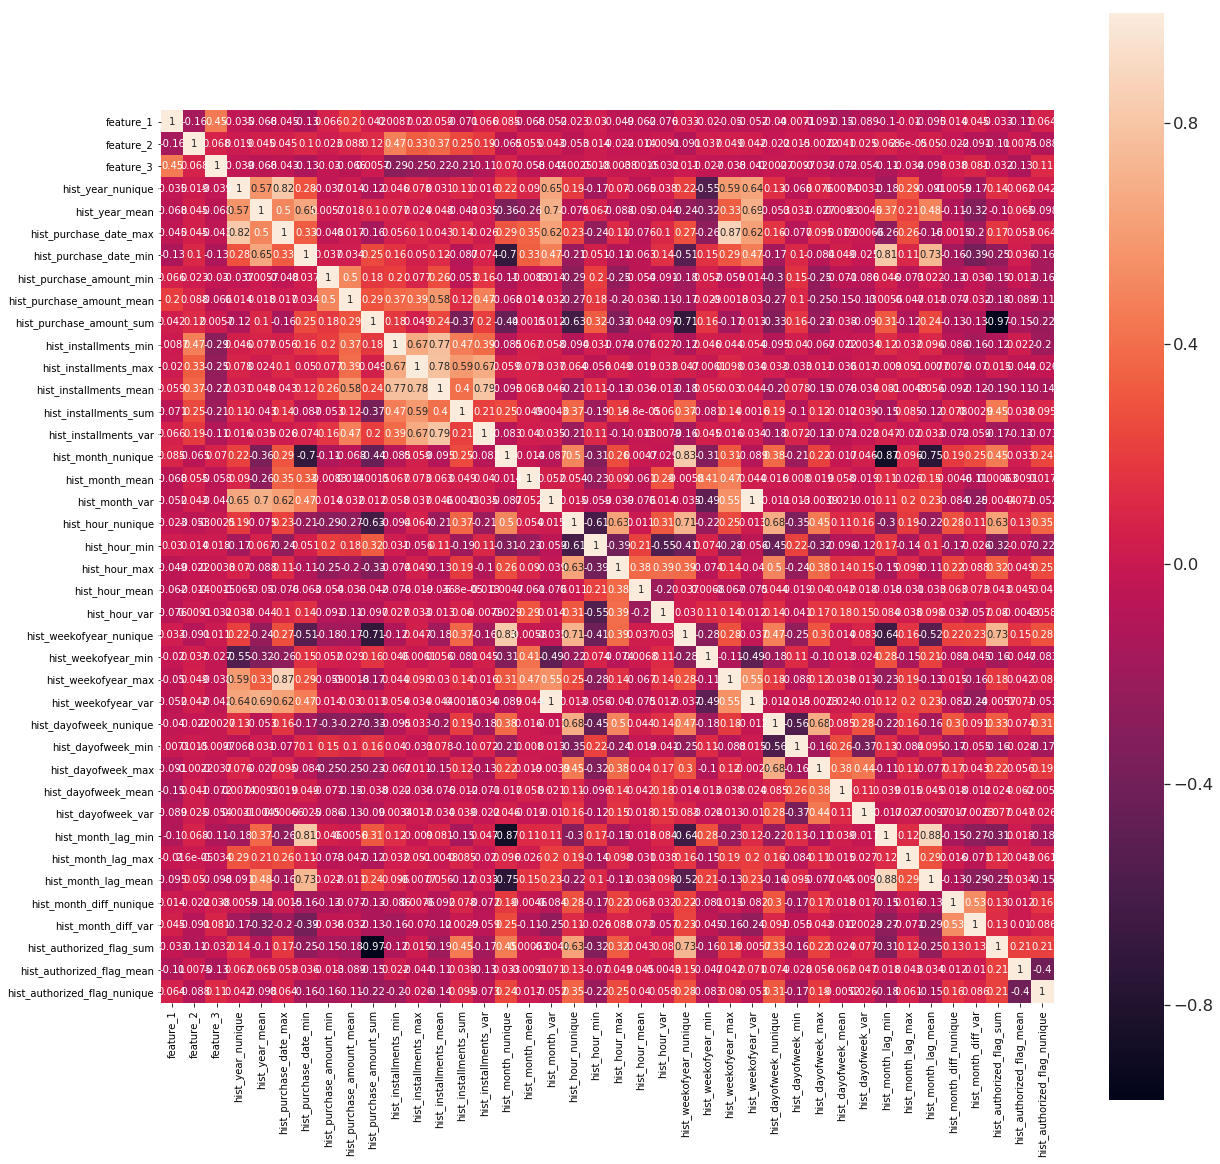

In [44]:
showCorr(train_df[train_columns[0:40]])

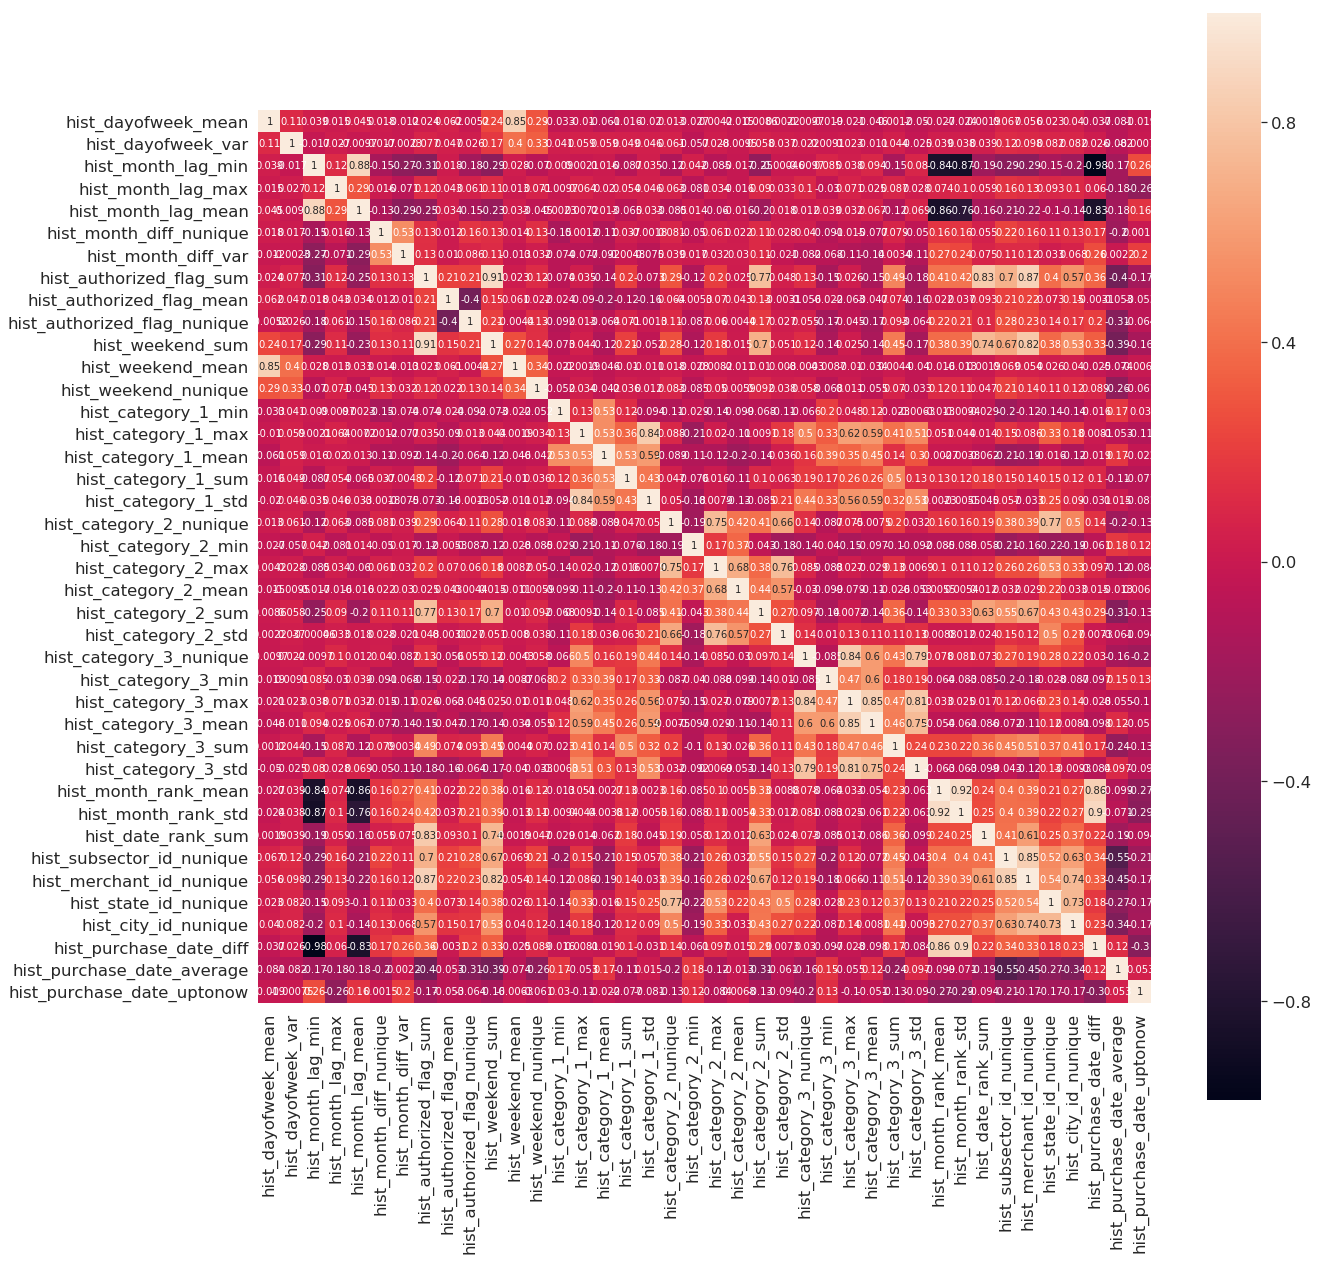

In [45]:
showCorr(train_df[train_columns[30:70]])

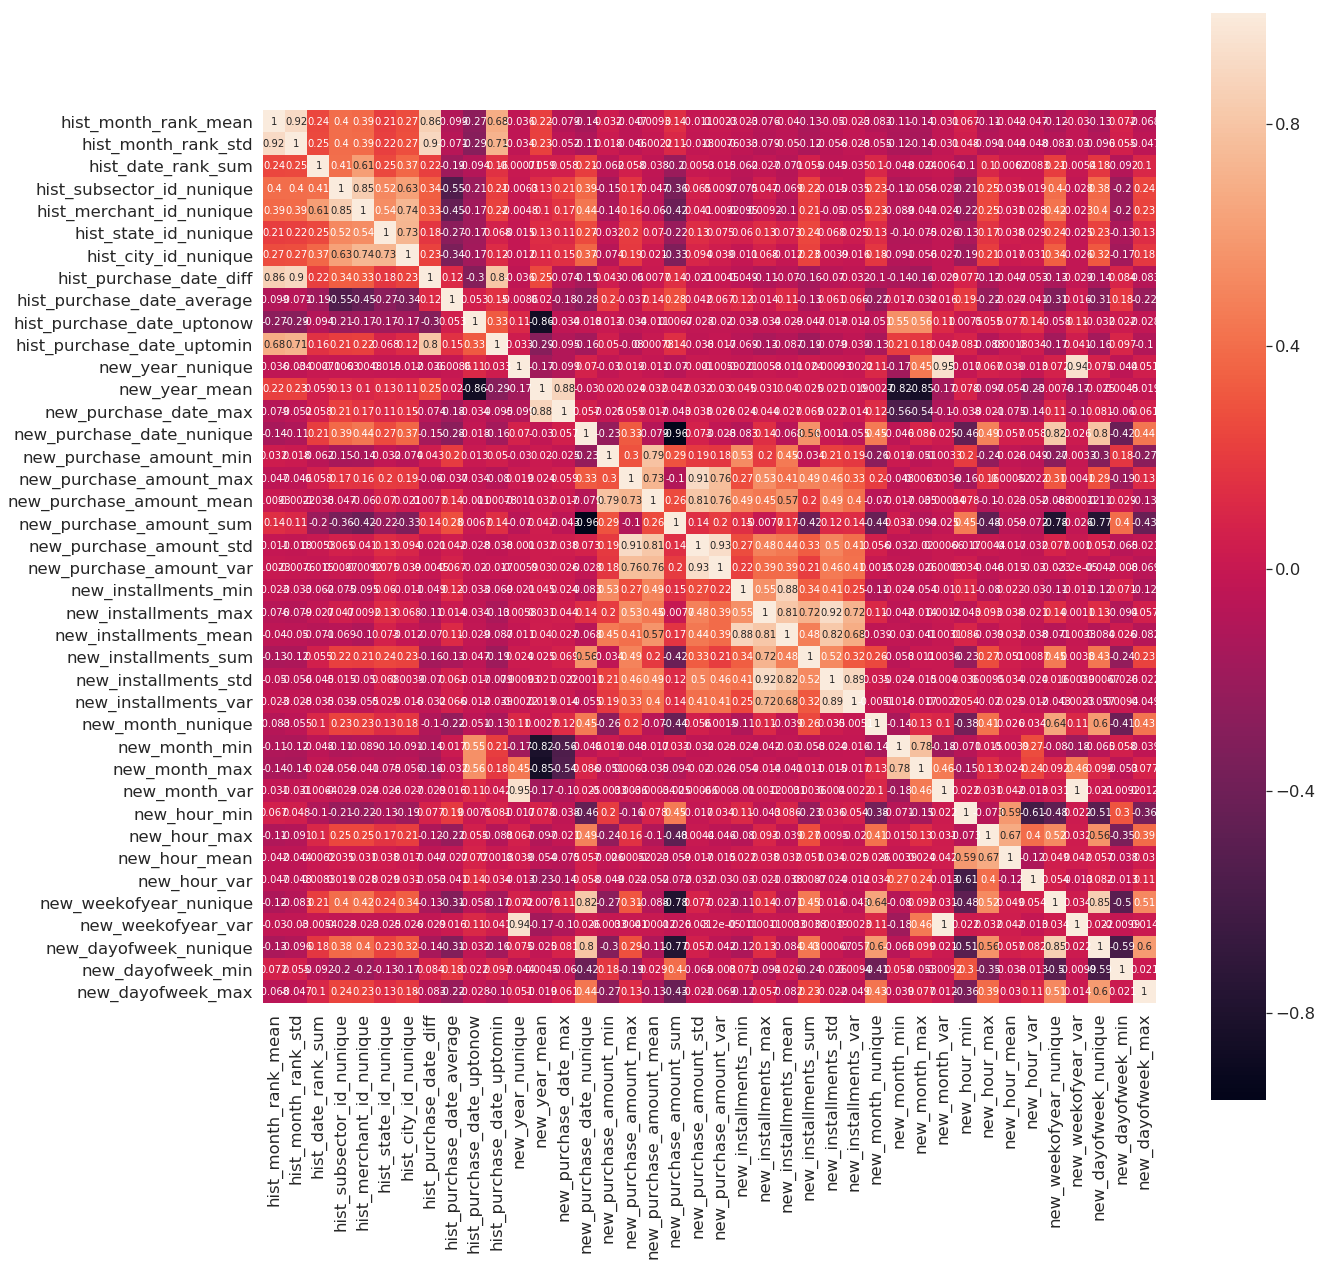

In [46]:
showCorr(train_df[train_columns[60:100]])

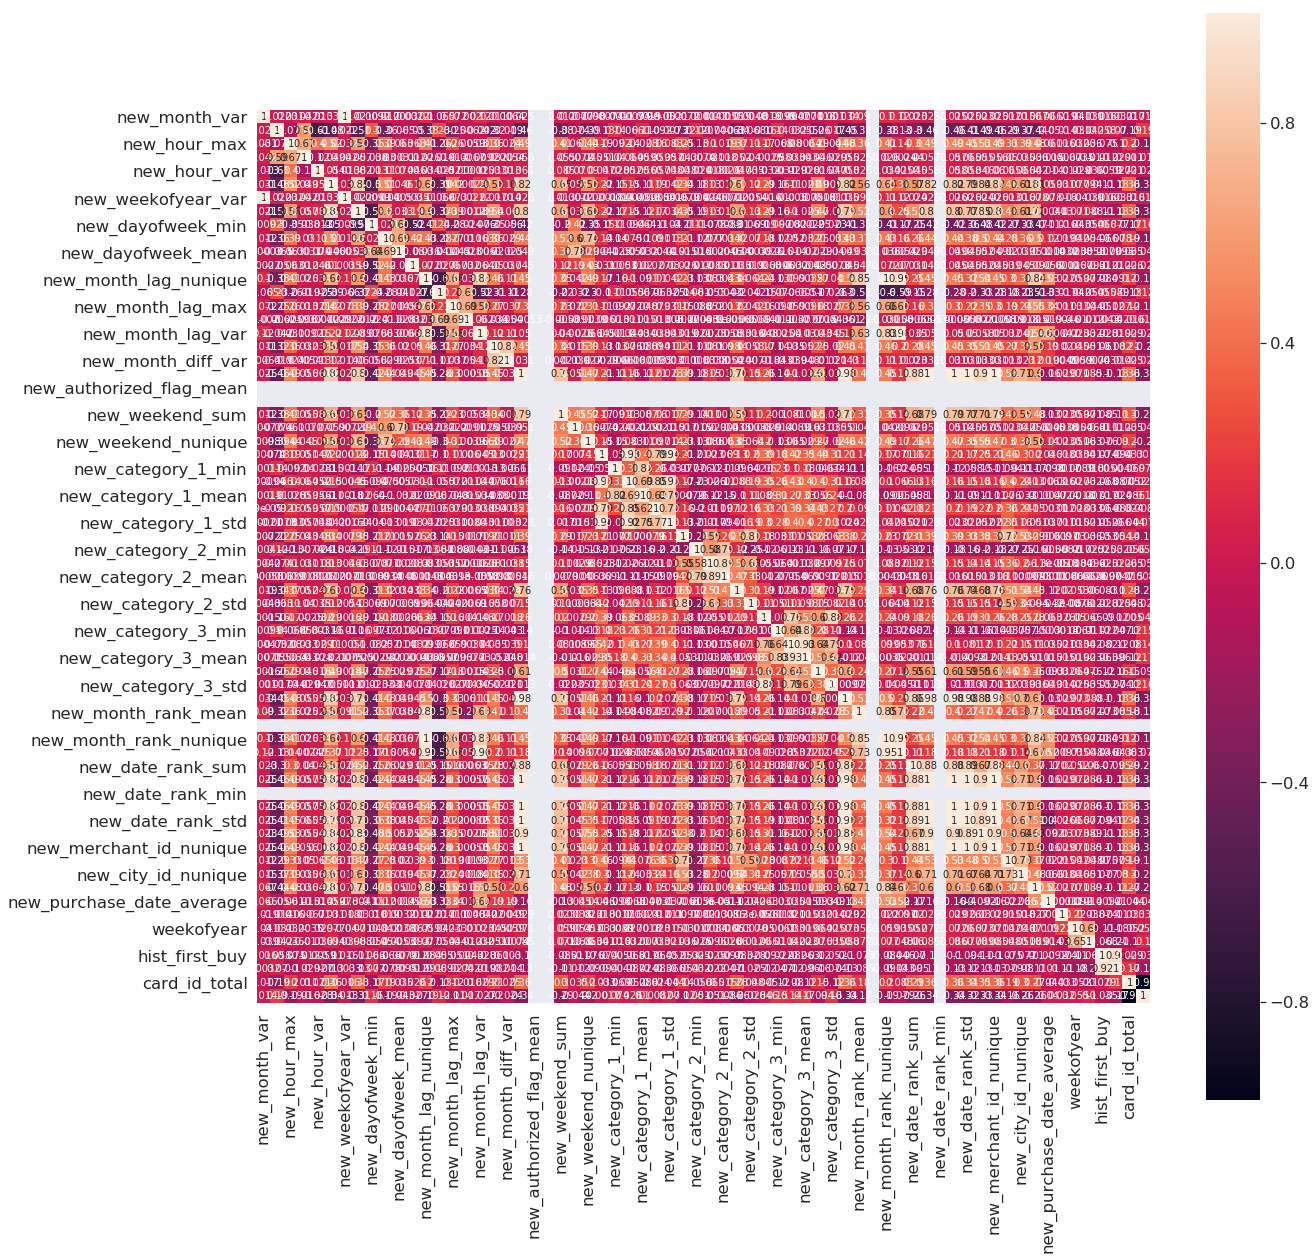

In [47]:
showCorr(train_df[train_columns[90:]])

In [48]:
len(train_columns)

156

In [49]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.007,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.85,
         "bagging_seed": 40,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2020}

In [50]:
#prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=20, shuffle=True, random_state=2020)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

In [51]:
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df,train_df['outliers'].values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 150)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.56918	valid_1's rmse: 3.71909
[400]	training's rmse: 3.45116	valid_1's rmse: 3.69369
[600]	training's rmse: 3.37065	valid_1's rmse: 3.68298
[800]	training's rmse: 3.30924	valid_1's rmse: 3.67704
[1000]	training's rmse: 3.25715	valid_1's rmse: 3.67522
[1200]	training's rmse: 3.21215	valid_1's rmse: 3.67335
[1400]	training's rmse: 3.17038	valid_1's rmse: 3.67286
Early stopping, best iteration is:
[1280]	training's rmse: 3.19535	valid_1's rmse: 3.67275
fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.57315	valid_1's rmse: 3.66296
[400]	training's rmse: 3.45483	valid_1's rmse: 3.62332
[600]	training's rmse: 3.37301	valid_1's rmse: 3.60905
[800]	training's rmse: 3.31167	valid_1's rmse: 3.60332
[1000]	training's rmse: 3.26023	valid_1's rmse: 3.59993
[1200]	training's rmse: 3.21424	valid_1's rmse: 3.599
Early stopping, best iteration is:
[1222]	training'

In [52]:
np.sqrt(mean_squared_error(oof, target))

3.654773351172034

In [53]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

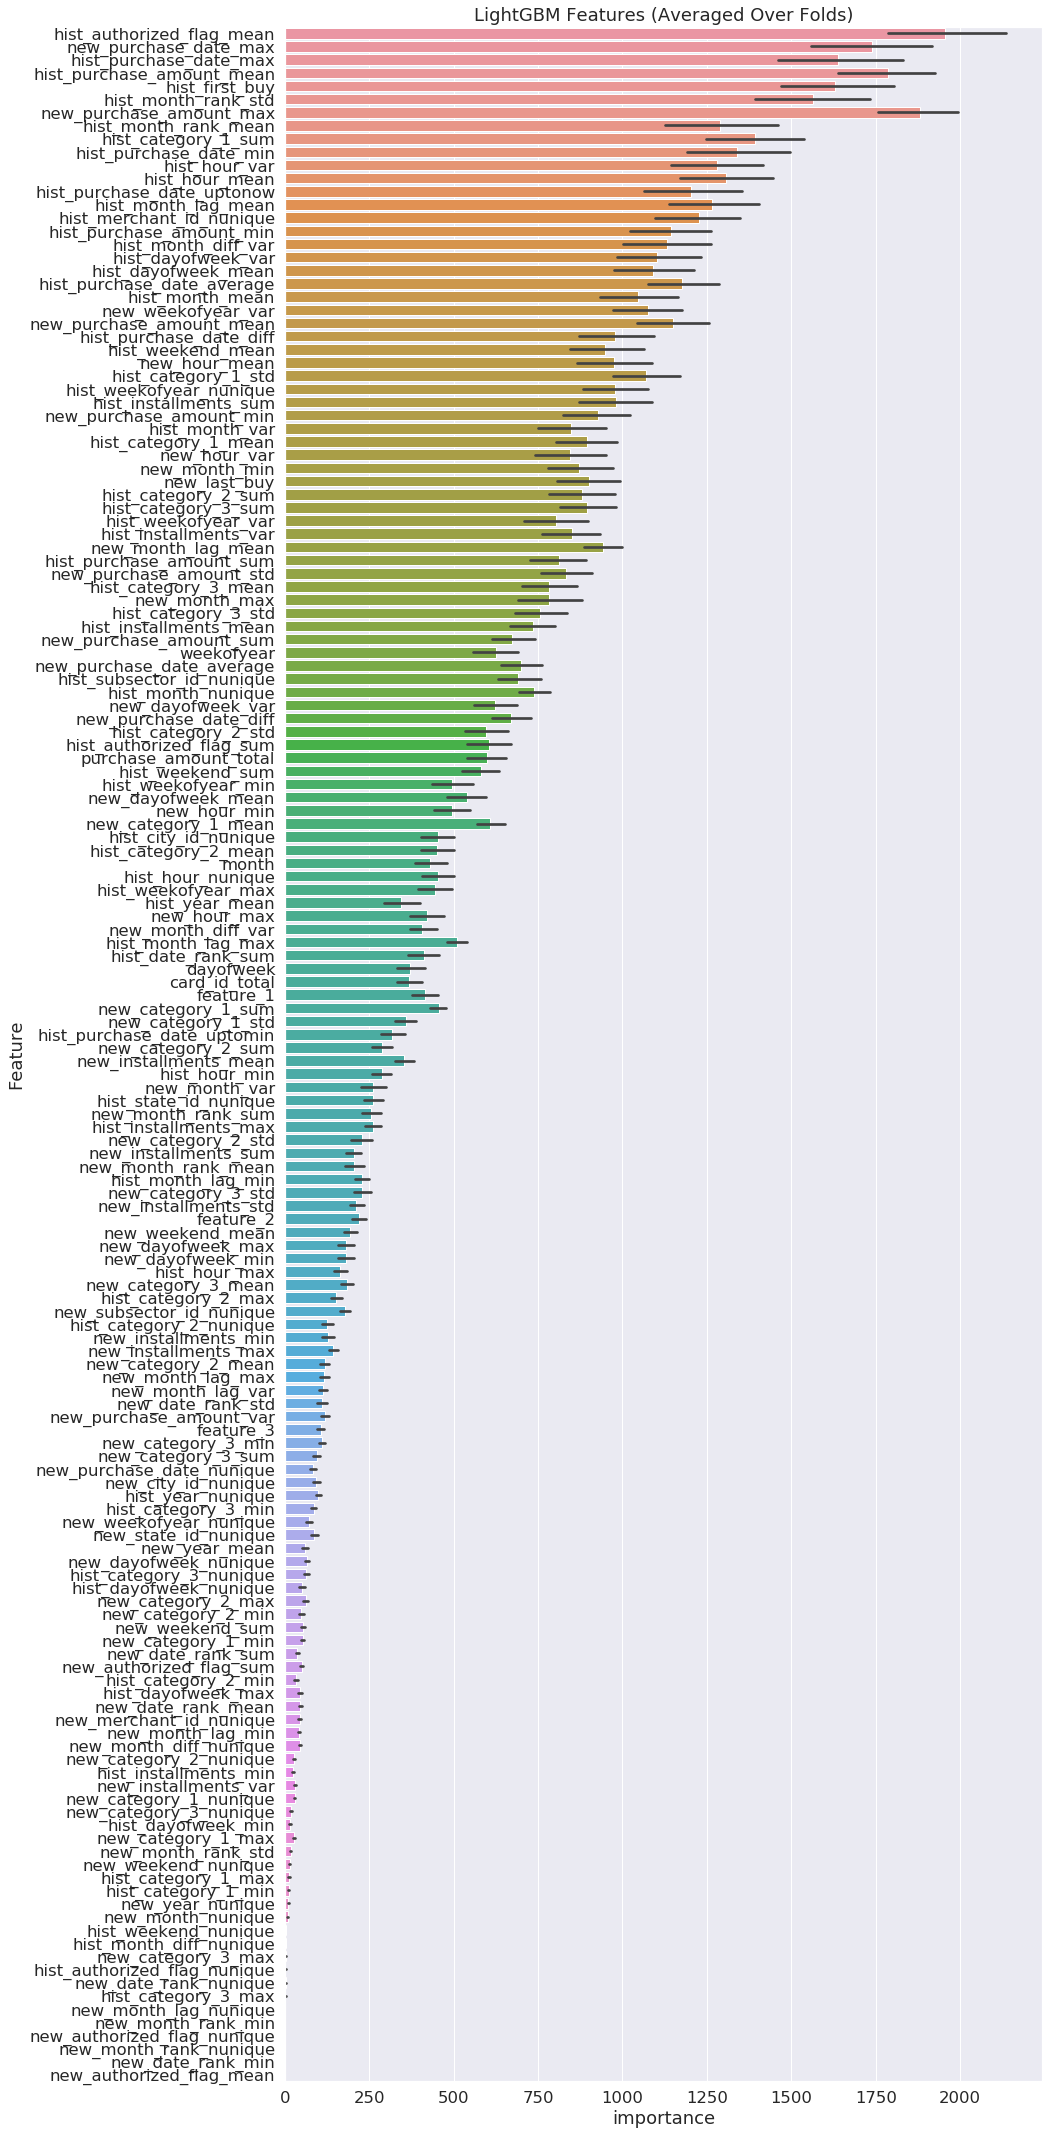

In [54]:
plt.figure(figsize=(15,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (Averaged Over Folds)')
plt.tight_layout()

In [55]:
##submission
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("DSA_Jun2019_Final.csv", index=False)